## Project :  Building a Spam Filter with Naive Bayes

#### Objective - The goal is to build a Spam Fitler using the Naive Bayes algorithm. We will analyze a set of 5572 SMSes and build the model using the same. We will aim for an accuracy of at least 80%. The data set location has been shared below.

#### Dataset locations

https://archive.ics.uci.edu/ml/datasets/sms+spam+collection

https://dq-content.s3.amazonaws.com/433/SMSSpamCollection

### Exploring the Dataset

In [1]:
import pandas as pd

In [2]:
sms_spam = pd.read_csv('SMSSpamCollection', sep= '\t', header = None, names = ['Label', 'SMS'])

In [3]:
sms_spam.head()

,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
sms_spam['Label'].value_counts()

ham     4825
spam     747
Name: Label, dtype: int64

In [5]:
sms_spam['Label'].value_counts().sum()

5572

In [6]:
sms_spam.shape

(5572, 2)

#### Thus we can observe that the entire dataset is labelled as either 'spam' or 'ham' (non-spam).

In [7]:
round(sms_spam['Label'].value_counts(normalize=True)*100,2)

ham     86.59
spam    13.41
Name: Label, dtype: float64

#### Spam - 13.41% and Ham(Non-Spam) - 86.59%

 ### Training and Test Set

To test the spam filter, we're first going to split our dataset into two categories:

1. A training set, which we'll use to "train" the computer how to classify messages.
2. A test set, which we'll use to test how good the spam filter is with classifying new messages.


We're going to keep 80% of our dataset for training, and 20% for testing (we want to train the algorithm on as much data as possible, but we also want to have enough test data). The dataset has 5,572 messages, which means that:

1. The training set will have 4,458 messages (about 80% of the dataset).
2. The test set will have 1,114 messages (about 20% of the dataset).

#### Randomizing the entire dataset

In [8]:
data_randomized = sms_spam.sample(frac = 1, random_state = 1)

In [9]:
### Generating Training and Test data

training_test_index = round((len(data_randomized)*0.8))

training_set = data_randomized[:training_test_index].reset_index(drop = True)
test_set = data_randomized[training_test_index:].reset_index(drop = True)


In [10]:
print(training_set.shape)
print(test_set.shape)

(4458, 2)
(1114, 2)


In [11]:
round(training_set['Label'].value_counts(normalize=True)*100,2)

ham     86.54
spam    13.46
Name: Label, dtype: float64

In [12]:
round(test_set['Label'].value_counts(normalize=True)*100,2)

ham     86.8
spam    13.2
Name: Label, dtype: float64

#### Thus we have the percentage split between Spam and Ham messages in nearly the same proportion as the original dataset. 

### Data Cleaning - Letter Case and Punctuation

To calculate all the probabilities required by the algorithm, we'll first need to perform a bit of data cleaning to bring the data in a format that will allow us to extract easily all the information we need.

We want to transform the data into the below format

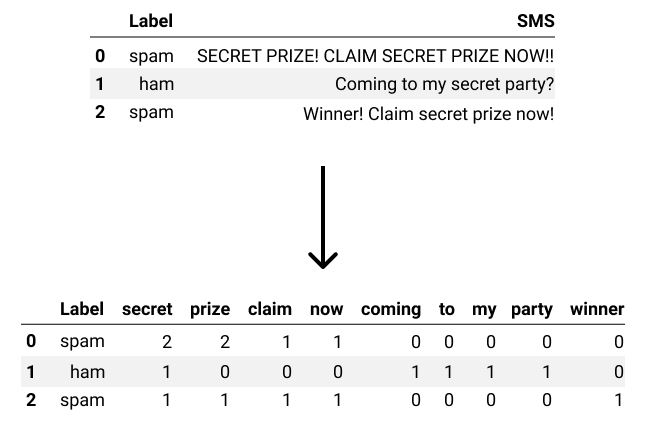

#### We will remove any punctuation marks from the messages and also convert all the words into lower case, so that they can be easily extracted. 

In [13]:
sample_string =  'Secret!! Money, goods.'

In [14]:
import re
training_set['SMS'].head()

0                         Yep, by the pretty sculpture
1        Yes, princess. Are you going to make me moan?
2                           Welp apparently he retired
3                                              Havent.
4    I forgot 2 ask ü all smth.. There's a card on ...
Name: SMS, dtype: object

In [15]:
training_set['SMS'] = training_set['SMS'].apply(lambda x : re.sub('\W', ' ', x)).str.lower()

In [16]:
training_set['SMS'].head()

0                         yep  by the pretty sculpture
1        yes  princess  are you going to make me moan 
2                           welp apparently he retired
3                                              havent 
4    i forgot 2 ask ü all smth   there s a card on ...
Name: SMS, dtype: object

#### Thus the punctuations have been removed from all the strings and they have also been converted into lower case. 

### Creating the Vocabulary

#### We will create a list of all unique words (the vocabulary) from the current data set. 

In [17]:
training_set['SMS'] = training_set['SMS'].str.split(' ')


In [18]:
training_set['SMS'].head()

0                  [yep, , by, the, pretty, sculpture]
1    [yes, , princess, , are, you, going, to, make,...
2                      [welp, apparently, he, retired]
3                                           [havent, ]
4    [i, forgot, 2, ask, ü, all, smth, , , there, s...
Name: SMS, dtype: object

In [19]:
vocabulary = []

In [20]:
def list_gen(list_of_strings):
    for item in list_of_strings:
        vocabulary.append(item)

In [21]:
training_set['SMS'].apply(list_gen)

0       None
1       None
2       None
3       None
4       None
        ... 
4453    None
4454    None
4455    None
4456    None
4457    None
Name: SMS, Length: 4458, dtype: object

In [22]:
vocabulary = list(set(vocabulary))

In [23]:
len(vocabulary)

7784

In [24]:
vocabulary.remove('')

#### Removing the whitespace and only words remain

In [25]:
len(vocabulary)

7783

#### Thus, we have created a list called 'vocabulary' that contains all the unique words in all the messages in the training set. 

### The Final Training Set

In [26]:
word_counts_per_sms = {}

In [27]:
word_counts_per_sms = {unique_word: [0] * len(training_set['SMS']) for unique_word in vocabulary}

In [28]:
for index,row_list in enumerate(training_set['SMS']):
    #print(index,row_list)
    for word in row_list:
        if word != '':
            word_counts_per_sms[word][index] += 1

In [29]:
df_word_counts_per_sms = pd.DataFrame(word_counts_per_sms)

In [30]:
#df_word_counts_per_sms =df_word_counts_per_sms.rename(columns = {'' : 'whitespace'})
df_word_counts_per_sms.head()

,practical,rodds1,sac,dryer,4few,anythin,dd,sq825,yuo,frndship,...,lark,atleast,tops,minute,ikea,08715203652,unknown,itxt,congrats,ryder
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
df_word_counts_per_sms.shape

(4458, 7783)

In [32]:
training_set_clean = pd.concat([training_set, df_word_counts_per_sms], axis = 1)

In [33]:
training_set_clean.head()

,Label,SMS,practical,rodds1,sac,dryer,4few,anythin,dd,sq825,...,lark,atleast,tops,minute,ikea,08715203652,unknown,itxt,congrats,ryder
0,ham,"[yep, , by, the, pretty, sculpture]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[yes, , princess, , are, you, going, to, make,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,"[havent, ]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,"[i, forgot, 2, ask, ü, all, smth, , , there, s...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Calculating the Constants -  P(Spam), P(ham), alpha, n_spam and n_ham

In [34]:
### Segregating the dataset into spam and non-spam

training_set_clean_spam = training_set_clean[training_set_clean['Label'] == 'spam']
training_set_clean_ham = training_set_clean[training_set_clean['Label'] == 'ham']

In [35]:
p_spam = len(training_set_clean_spam) / len(training_set_clean)
p_ham = len(training_set_clean_ham) / len(training_set_clean)

In [36]:
p_spam

0.13458950201884254

In [37]:
p_ham

0.8654104979811574

In [38]:
alpha = 1 # Applying Laplace Smoothing

n_spam_words = training_set_clean_spam[training_set_clean_spam.columns[2:]].sum().sum()
n_ham_words = training_set_clean_ham[training_set_clean_ham.columns[2:]].sum().sum()

### Calculating the Parameters - P(word | Spam), P(word | ham) for all words in the vocabulary

#### Creating two dictionaries to store P(word | spam) and P(word | ham) for all words in the vocabulary

In [39]:
dict_word_given_spam = {} 
dict_word_given_ham = {}


for word in training_set_clean_spam.columns[3:]: #Excluding the columns of Label, SMS and whitespace
    
    word_count = training_set_clean_spam[word].sum()
    word_prob_given_spam = (word_count + alpha)/(n_spam_words + (alpha*len(vocabulary)))
    dict_word_given_spam[word] = word_prob_given_spam

for word in training_set_clean_ham.columns[3:]: #Excluding the columns of Label, SMS and whitespace
    
    word_count = training_set_clean_ham[word].sum()
    word_prob_given_ham = (word_count + alpha)/(n_ham_words + (alpha*len(vocabulary)))
    dict_word_given_ham[word] = word_prob_given_ham

In [40]:
sms_spam.head()

,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Classifying A New Message

In [41]:
def spam_or_ham(message):
    #import re
    message = re.sub('\W', ' ', message)
    message = message.lower()
    word_list = message.split()
    
  
    word_list = list(set(word_list))
    if '' in word_list:
        word_list = word_list.remove('')
    
    p_spam_words =p_spam
    p_ham_words = p_ham
    
    for word in word_list:
        if word in vocabulary:
            p_spam_words*= dict_word_given_spam[word]
            p_ham_words*= dict_word_given_ham[word]
    
    print('P(Spam|message):', p_spam_words)
    print('P(Ham|message):', p_ham_words)
    
    if p_spam_words > p_ham_words:
        return 'spam'
    elif p_spam_words < p_ham_words :        
        return 'ham'
    else:
        return 'Please request a human for the Spam/Non-Spam classification'



#### Testing against existing classifications

In [42]:
print(sms_spam.head(4))

  Label                                                SMS
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...


In [43]:
sms_spam.iloc[3]

Label                                                  ham
SMS      U dun say so early hor... U c already then say...
Name: 3, dtype: object

In [44]:
spam_or_ham(sms_spam['SMS'][3])

P(Spam|message): 3.5421068202189984e-34
P(Ham|message): 1.8831224557496194e-27


'ham'

In [45]:
sms_spam.iloc[2]

Label                                                 spam
SMS      Free entry in 2 a wkly comp to win FA Cup fina...
Name: 2, dtype: object

In [46]:
spam_or_ham(sms_spam['SMS'][2])

P(Spam|message): 2.4467940390459243e-87
P(Ham|message): 1.3834227834990107e-105


'spam'

#### Testing new classifications

In [47]:
spam_or_ham('WINNER!! This is the secret code to unlock the money: C3421.')

P(Spam|message): 1.9601625317988245e-23
P(Ham|message): 1.3673295850585385e-25


'spam'

In [48]:
spam_or_ham("Sounds good, Tom, then see u there")

P(Spam|message): 2.4372375665888117e-25
P(Ham|message): 3.687530435009238e-21


'ham'

### Measuring the Spam Filter's Accuracy

In [49]:
#Removing the print statements
def spam_or_ham(message):
    #import re
    message = re.sub('\W', ' ', message)
    message = message.lower()
    word_list = message.split()
    
  
    word_list = list(set(word_list))
    if '' in word_list:
        word_list = word_list.remove('')
    
    p_spam_words =p_spam
    p_ham_words = p_ham
    
    for word in word_list:
        if word in vocabulary:
            p_spam_words*= dict_word_given_spam[word]
            p_ham_words*= dict_word_given_ham[word]
    
    #print('P(Spam|message):', p_spam_words)  #Removing the print statements, as we want to use this function with apply()
    #print('P(Ham|message):', p_ham_words)
    
    if p_spam_words > p_ham_words:
        return 'spam'
    elif p_spam_words < p_ham_words :        
        return 'ham'
    else:
        return 'Please request a human for the Spam/Non-Spam classification'



In [50]:
test_set['test_label'] = test_set['SMS'].apply(spam_or_ham)

In [51]:
test_set['accuracy_check'] = test_set['test_label'] == test_set['Label']

In [52]:
test_set['accuracy_check'].value_counts()

True     1101
False      13
Name: accuracy_check, dtype: int64

In [53]:
test_set['accuracy_check'].value_counts(normalize = True)*100

True     98.833034
False     1.166966
Name: accuracy_check, dtype: float64

### Conclusion

In this project, we managed to build a spam filter for SMS messages using the multinomial Naive Bayes algorithm. The filter had an accuracy of 98.83% on the test set, which is an excellent result. We initially aimed for an accuracy of over 80%, but we managed to do way better than that.